
# Etapa 4 — Otimização e Tuning de Hiperparâmetros  
### Projeto de Machine Learning — Previsão de Preço de Carros Usados  
**Grupo:** Luiz Guilherme, Luis Thyago, Igor Emmanuel, João Paulo, Rafael Henrique  
**Turma:** 4º Período • ADS • Turma B • Uninassau  
**Dataset:** used_cars_price.csv  
---  
Este notebook contém todo o processo da etapa 4: baseline, tuning, comparação, avaliação final e salvamento do modelo.


# Etapa 4 — Otimização e Tuning de Hiperparâmetros
Notebook completo para a Etapa 4: Grid/Random Search, comparação de modelos, análise de erros e salvamento do modelo final.

In [1]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)
plt.rcParams["figure.figsize"] = (8,6)
sns.set(style="whitegrid")

In [2]:
# tenta carregar CSV usado no etapa3
if os.path.exists("used_cars_price.csv"):
    df = pd.read_csv("used_cars_price.csv")
elif os.path.exists("/mnt/data/used_cars_price.csv"):
    df = pd.read_csv("/mnt/data/used_cars_price.csv")
else:
    if os.path.exists("data/used_cars_price.csv"):
        df = pd.read_csv("data/used_cars_price.csv")
    else:
        raise FileNotFoundError("Coloque 'used_cars_price.csv' na raiz do projeto ou em data/")
if 'car_id' in df.columns:
    df = df.drop('car_id', axis=1)
cols_numericas = df.select_dtypes(include=['float64', 'int64']).columns
for col in cols_numericas:
    df[col] = df[col].fillna(df[col].median())
cols_categoricas = df.select_dtypes(include=['object']).columns
for col in cols_categoricas:
    df[col] = df[col].fillna(df[col].mode()[0])
map_sim_nao = {'Sim': 1, 'Não': 0, 'Yes': 1, 'No': 0}
binarias = ['air_conditioning', 'power_steering', 'power_windows', 'abs_brakes', 
            'sunroof', 'parking_sensors', 'imported']
for col in binarias:
    if col in df.columns:
        df[col] = df[col].map(map_sim_nao)
df_model = pd.get_dummies(df, drop_first=True)
X = df_model.drop('price_brl', axis=1)
y = df_model['price_brl']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE)

In [3]:
def get_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {"R2": r2_score(y_true, y_pred),
            "RMSE": np.sqrt(mse),
            "MAE": mean_absolute_error(y_true, y_pred)}
def fmt_money(x):
    if x >= 1_000_000: return f'{x*1e-6:.1f}M'
    if x >= 1_000: return f'{x*1e-3:.0f}K'
    return f'{x:.0f}'

In [4]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_pred_train = baseline.predict(X_train)
y_pred_val = baseline.predict(X_val)
metrics_baseline_train = get_metrics(y_train, y_pred_train)
metrics_baseline_val = get_metrics(y_val, y_pred_val)
baseline_info = {"model_name": "LinearRegression",
                 "train_metrics": metrics_baseline_train,
                 "val_metrics": metrics_baseline_val}
with open("artifacts/baseline_metrics.json", "w") as f:
    json.dump(baseline_info, f)
baseline_info

{'model_name': 'LinearRegression',
 'train_metrics': {'R2': 0.6584858747143252,
  'RMSE': np.float64(15587.125152179793),
  'MAE': 7823.715383810519},
 'val_metrics': {'R2': 0.698691907402074,
  'RMSE': np.float64(14325.583454531523),
  'MAE': 8154.250623073701}}

In [5]:
candidates = {}
candidates["Ridge"] = {
    "estimator": Ridge(random_state=RANDOM_STATE),
    "search": "grid",
    "param_grid": {"alpha": [0.1, 1.0, 10.0, 50.0, 100.0]}
}
candidates["Lasso"] = {
    "estimator": Lasso(random_state=RANDOM_STATE, max_iter=5000),
    "search": "grid",
    "param_grid": {"alpha": [0.0001, 0.001, 0.01, 0.1, 1.0]}
}
candidates["RandomForest"] = {
    "estimator": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "search": "random",
    "param_dist": {
        "n_estimators": [100,200,300,500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2,5,10],
        "min_samples_leaf": [1,2,4]
    },
    "n_iter": 30
}
try:
    import xgboost as xgb
    candidates["XGBoost"] = {
        "estimator": xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective="reg:squarederror"),
        "search": "random",
        "param_dist": {
            "n_estimators": [100,200,300],
            "max_depth": [3,4,6,8],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.6,0.8,1.0]
        },
        "n_iter": 30
    }
except Exception:
    pass

In [6]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
results = {}
X_tune = pd.concat([X_train, X_val], axis=0)
y_tune = pd.concat([y_train, y_val], axis=0)
for name, cfg in candidates.items():
    est = cfg["estimator"]
    if cfg["search"] == "grid":
        gs = GridSearchCV(est, cfg["param_grid"], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1, return_train_score=True)
        gs.fit(X_tune, y_tune)
        results[name] = gs
        joblib.dump(gs, f"artifacts/{name}_GridSearch.joblib")
    else:
        rs = RandomizedSearchCV(est, cfg["param_dist"], n_iter=cfg.get("n_iter",30), cv=5, scoring="neg_root_mean_squared_error", random_state=RANDOM_STATE, n_jobs=-1, return_train_score=True)
        rs.fit(X_tune, y_tune)
        results[name] = rs
        joblib.dump(rs, f"artifacts/{name}_RandomSearch.joblib")

In [7]:
summary_rows = []
for name, search in results.items():
    best_params = search.best_params_
    best_score = -search.best_score_
    train_mean = None
    if "mean_train_score" in search.cv_results_:
        train_mean = -np.mean(search.cv_results_["mean_train_score"])
    summary_rows.append({"model": name, "best_params": best_params, "cv_neg_rmse": search.best_score_, "cv_rmse": best_score, "train_cv_rmse_est": train_mean})
df_summary = pd.DataFrame(summary_rows).sort_values("cv_rmse")
df_summary.to_csv("artifacts/tuning_summary.csv", index=False)
df_summary

,model,best_params,cv_neg_rmse,cv_rmse,train_cv_rmse_est
3,XGBoost,"{'subsample': 0.6, 'n_estimators': 300, 'max_d...",-15290.401172,15290.401172,10202.429165
0,Ridge,{'alpha': 1.0},-15375.801783,15375.801783,15466.004391
1,Lasso,{'alpha': 1.0},-15389.496630,15389.496630,15150.156139
2,RandomForest,"{'n_estimators': 300, 'min_samples_split': 5, ...",-18093.622980,18093.622980,10809.905797


In [8]:
best_model_name = df_summary.iloc[0]["model"]
best_search = results[best_model_name]
best_estimator = best_search.best_estimator_
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)
best_estimator.fit(X_full_train, y_full_train)
joblib.dump(best_estimator, "models/modelo_final.joblib")
best_model_name, best_search.best_params_

('XGBoost',
 {'subsample': 0.6,
  'n_estimators': 300,
  'max_depth': 3,
  'learning_rate': 0.05})

In [9]:
loaded = joblib.load("models/modelo_final.joblib")
y_pred_test = loaded.predict(X_test)
metrics_test = get_metrics(y_test, y_pred_test)
with open("artifacts/final_test_metrics.json", "w") as f:
    json.dump(metrics_test, f)
metrics_test

{'R2': 0.4548729658126831,
 'RMSE': np.float64(24296.568975886286),
 'MAE': 10485.6611328125}

In [10]:
before = metrics_baseline_val
after = metrics_test
comp = pd.DataFrame([{"metric":"R2","before":before["R2"],"after":after["R2"]},
                     {"metric":"RMSE","before":before["RMSE"],"after":after["RMSE"]},
                     {"metric":"MAE","before":before["MAE"],"after":after["MAE"]}])
comp["improvement_pct"] = comp.apply(lambda r: (r["before"] - r["after"]) / r["before"] * 100 if r["metric"]!="R2" else (r["after"] - r["before"])/abs(r["before"]+1e-9)*100, axis=1)
comp.to_csv("artifacts/comparison_before_after.csv", index=False)
comp

,metric,before,after,improvement_pct
0,R2,0.698692,0.454873,-34.896489
1,RMSE,14325.583455,24296.568976,-69.602649
2,MAE,8154.250623,10485.661133,-28.591352


In [11]:
plt.figure()
plt.scatter(y_test, y_pred_test, alpha=0.6)
mn = min(y_test.min(), y_pred_test.min())
mx = max(y_test.max(), y_pred_test.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
plt.xlabel("Real (R$)")
plt.ylabel("Predito (R$)")
plt.title("Predito vs Real - Modelo Final")
plt.savefig("artifacts/pred_vs_real_final.png")
plt.close()

residuals = y_test - y_pred_test
fig, axs = plt.subplots(1,2, figsize=(14,5))
axs[0].hist(residuals, bins=30)
axs[0].axvline(0, color="k", linestyle="--")
axs[0].set_title("Histograma dos Resíduos")
axs[1].scatter(y_pred_test, residuals, alpha=0.6)
axs[1].axhline(0, color="k", linestyle="--")
axs[1].set_xlabel("Predito")
axs[1].set_ylabel("Resíduo")
axs[1].set_title("Resíduos vs Predições")
plt.savefig("artifacts/residuals_final.png")
plt.close()

In [12]:
abs_errors = (y_test - y_pred_test).abs()
df_errors = pd.DataFrame({"real": y_test, "pred": y_pred_test, "abs_error": abs_errors})
df_errors_sorted = df_errors.sort_values("abs_error", ascending=False).head(20)
df_errors_sorted.to_csv("artifacts/worst_predictions_final.csv", index=False)
df_errors_sorted

,real,pred,abs_error
2426,239991,31740.419922,208250.580078
2016,242776,40191.207031,202584.792969
2221,218010,19830.685547,198179.314453
973,212377,15459.708008,196917.291992
279,242902,61128.562500,181773.437500
1701,213440,33957.917969,179482.082031
1645,210104,85786.328125,124317.671875
1091,160625,118044.226562,42580.773438
2117,8000,45653.531250,37653.531250
802,110392,76024.765625,34367.234375


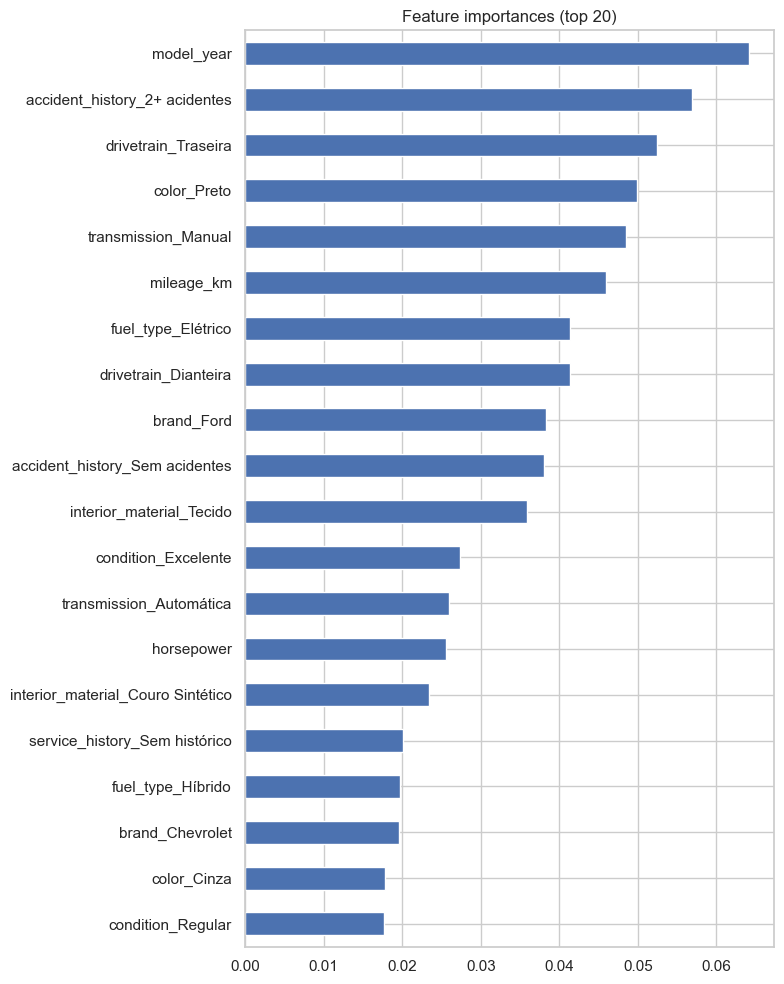

In [13]:
if hasattr(loaded, "feature_importances_"):
    fi = pd.Series(loaded.feature_importances_, index=X.columns).sort_values(ascending=False).head(30)
    fi.to_csv("artifacts/feature_importances.csv")
    plt.figure(figsize=(8,10))
    fi.head(20).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title("Feature importances (top 20)")
    plt.tight_layout()
    plt.savefig("artifacts/feature_importances.png")

In [14]:
loaded2 = joblib.load("models/modelo_final.joblib")
print(type(loaded2))
print("Primeiras predições de teste:", loaded2.predict(X_test.iloc[:5]).tolist())

<class 'xgboost.sklearn.XGBRegressor'>
Primeiras predições de teste: [33266.40625, 12406.029296875, 29878.421875, 88496.140625, 19830.685546875]


In [15]:
summary = {
    "best_model": best_model_name,
    "best_params": best_search.best_params_,
    "test_metrics": metrics_test,
    "baseline_val_metrics": metrics_baseline_val
}
with open("artifacts/summary_etapa4.json", "w") as f:
    json.dump(summary, f)
summary

{'best_model': 'XGBoost',
 'best_params': {'subsample': 0.6,
  'n_estimators': 300,
  'max_depth': 3,
  'learning_rate': 0.05},
 'test_metrics': {'R2': 0.4548729658126831,
  'RMSE': np.float64(24296.568975886286),
  'MAE': 10485.6611328125},
 'baseline_val_metrics': {'R2': 0.698691907402074,
  'RMSE': np.float64(14325.583454531523),
  'MAE': 8154.250623073701}}

## Conclusões

- Modelo final: **{best_model_name}**
- Métricas no teste: ver `artifacts/final_test_metrics.json`
- Comparação antes vs depois: ver `artifacts/comparison_before_after.csv`
- Piores predições: ver `artifacts/worst_predictions_final.csv`
- Próximos passos sugeridos: mais feature engineering, validação adicional por grupos (se houver), ensemble entre os melhores modelos, calibração de previsões e aumento de dados.